In [1]:
import numpy as np
import math
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
%matplotlib qt
plt.rcParams['figure.figsize']=[15,15]

# Simulation Parameters

In [65]:
num_modes = 25*2 #Number of temporal modes in the cluster (ie two spatial modes A & B for every temporal mode)
bs_1 = 25  #Delay line for the first beam splitter
bs_2 = 1 #Delay line for the second beam splitter - not implemented yet
bs_3 = 4
r = 1 #Squeezing parameter for input single-mode squeezed states
mod_buffer = 0

# Generating sympletic matrices

Note that the sympletic matrices have the form: $(x_1,x_2,x_3,..,p_1,p_2,p_3,...)$

In [66]:
#Single mode squeezing on all modes

S_sqz = np.array([])

for i in range(num_modes*2):
    if i == 0:
        S_sqz = np.diag([np.exp(r), np.exp(-r)])
    else:
        size = np.shape(S_sqz)
        S_sqz = np.block([
            [S_sqz[:int(size[0]/2),:int(size[0]/2)],np.zeros((int(size[1]/2),1)), S_sqz[int(size[0]/2):,:int(size[0]/2)],np.zeros((int(size[1]/2),1))],
            [np.zeros((1,int(size[0]/2))), np.array(np.exp(r)), np.zeros((1,int(size[0]/2))), np.array(0)],
            [S_sqz[int(size[0]/2):,:int(size[0]/2)], np.zeros((int(size[1]/2),1)), S_sqz[int(size[0]/2):,int(size[0]/2):], np.zeros((int(size[1]/2),1))],
            [np.zeros((1,int(size[0]/2))), np.array(0), np.zeros((1,int(size[0]/2))), np.array(np.exp(-r))]
        ])

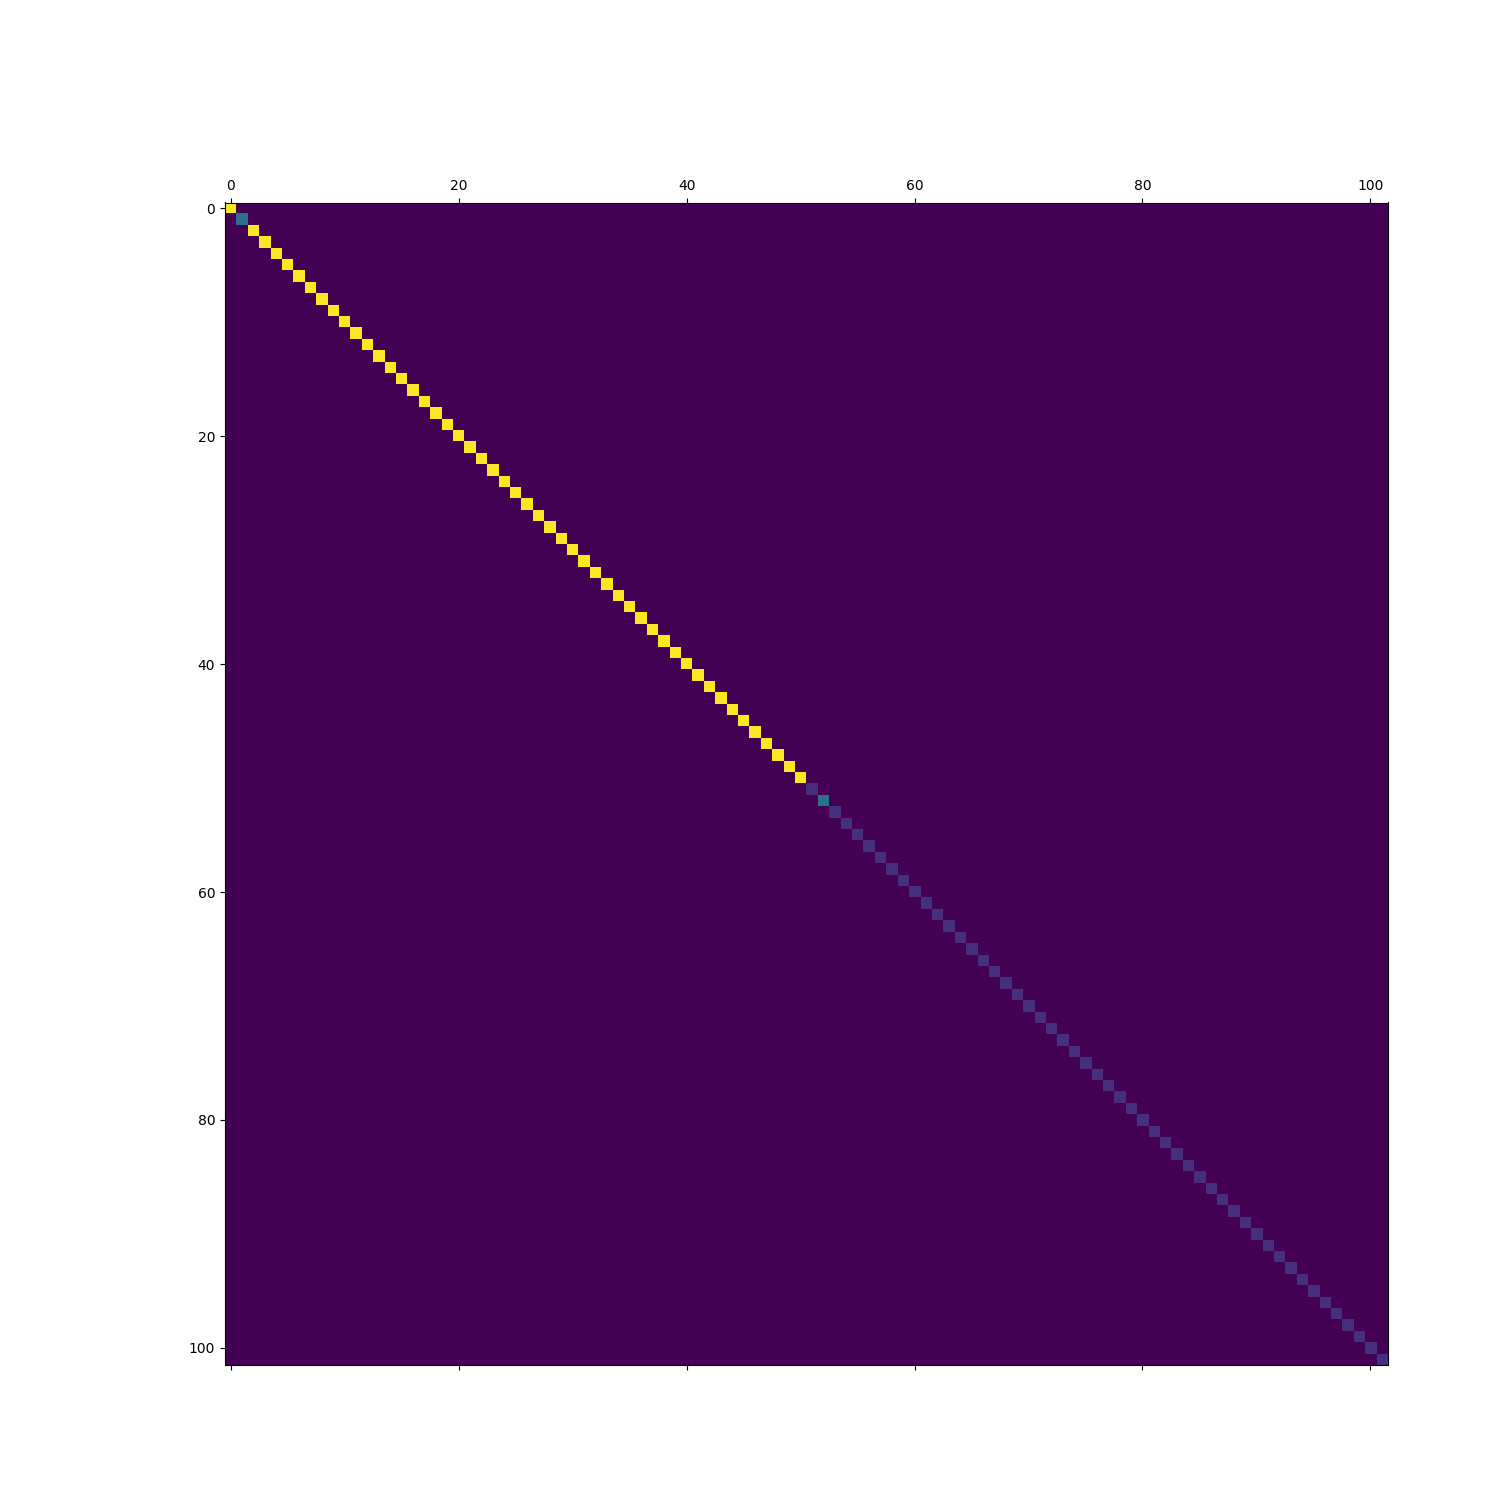

In [85]:
plt.matshow((S_in))

In [67]:
#Delay on B mode

S_phase_delay = np.zeros(np.shape(S_sqz))

for i in range(num_modes):
    S_phase_delay[i*2,i*2] = 1
    S_phase_delay[(num_modes+i)*2,(num_modes+i)*2] = 1
    S_phase_delay[i*2+1,(num_modes+i)*2+1] = -1
    S_phase_delay[(num_modes+i)*2+1,i*2+1] = 1

In [68]:
#Beamsplitter for EPR state generation

S_bs0 = np.array([])

for i in range(num_modes):
    bs_block = np.array([[1/np.sqrt(2),-1/np.sqrt(2)],[1/np.sqrt(2),1/np.sqrt(2)]])
    if i == 0:
        S_bs0 = np.block([
            [bs_block, np.zeros((2,2))],
            [np.zeros((2,2)), bs_block]
        ])
    else:
        size = np.shape(S_bs0)
        S_bs0 = np.block([
            [S_bs0[:int(size[0]/2),:int(size[0]/2)],np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,:int(size[0]/2)],np.zeros((int(size[1]/2),2))],
            [np.zeros((2,int(size[0]/2))), bs_block, np.zeros((2,int(size[0]/2))), np.zeros((2,2))],
            [S_bs0[int(size[0]/2):,:int(size[0]/2)], np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,int(size[0]/2):], np.zeros((int(size[1]/2),2))],
            [np.zeros((2,int(size[0]/2))), np.zeros((2,2)), np.zeros((2,int(size[0]/2))), bs_block]
        ])

In [69]:
#Beamsplitter for 1D cluster generation

bs1_block = np.diag(np.ones(num_modes*2))

for i in range(num_modes):
    if 2*i+1+(2*bs_1-1) < num_modes*2:
        bs1_block[2*i+1,2*i+1] = 1/np.sqrt(2)
        bs1_block[2*i+1,2*i+1+(2*bs_1-1)] = -1/np.sqrt(2)
        bs1_block[2*i+1+(2*bs_1-1),2*i+1] = 1/np.sqrt(2)
        bs1_block[2*i+1+(2*bs_1-1),2*i+1+(2*bs_1-1)] = 1/np.sqrt(2)

S_bs1 = np.block([[bs1_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs1_block]])     

In [70]:
#Beamsplitter for 2D cluster generation

bs2_block = np.diag(np.ones(num_modes*2))

for i in range(num_modes):
    if 2*i+1+(2*bs_2-1) < num_modes*2:
        bs2_block[2*i+1,2*i+1] = 1/np.sqrt(2)
        bs2_block[2*i+1,2*i+1+(2*bs_2-1)] = -1/np.sqrt(2)
        bs2_block[2*i+1+(2*bs_2-1),2*i+1] = 1/np.sqrt(2)
        bs2_block[2*i+1+(2*bs_2-1),2*i+1+(2*bs_2-1)] = 1/np.sqrt(2)

S_bs2 = np.block([[bs2_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs2_block]])  

In [71]:
bs3_block = np.diag(np.ones(num_modes*2))

for i in range(num_modes):
    if 2*i+1+(2*bs_3-1) < num_modes*2:
        bs3_block[2*i+1,2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1,2*i+1+(2*bs_3-1)] = -1/np.sqrt(2)
        bs3_block[2*i+1+(2*bs_3-1),2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1+(2*bs_3-1),2*i+1+(2*bs_3-1)] = 1/np.sqrt(2)

S_bs3 = np.block([[bs3_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs3_block]])  

In [72]:
#Bipartition rotation to convert H-graph into Approximate Cluster State

S_h2c = np.zeros(np.shape(S_sqz))
i = 0
while 2*(i*bs_1)<=num_modes*4:
    for k in range(bs_1):
        try:
            S_h2c[2*(k+i*bs_1), 2*(k+i*bs_1)] = 1
        except:
            pass
        try:
            S_h2c[2*(k+i*bs_1)+1, 2*(k+i*bs_1)+1+num_modes*2] = -1
            S_h2c[2*(k+i*bs_1)+1+num_modes*2, 2*(k+i*bs_1)+1] = 1
        except:
            pass
    for k in range(bs_1):
        try:
            S_h2c[2*(k+(i+1)*bs_1), 2*(k+(i+1)*bs_1)+num_modes*2] = -1
            S_h2c[2*(k+(i+1)*bs_1)+num_modes*2, 2*(k+(i+1)*bs_1)] = 1
        except:
            pass
        try:
            S_h2c[2*(k+(i+1)*bs_1)+1, 2*(k+(i+1)*bs_1)+1] = 1
        except:
            pass
    i += 1


# Calculate Covariance Matrix after transformation

In [75]:
S = S_bs3@S_bs2@S_bs1@S_bs0@S_phase_delay@S_sqz
# S = S_bs0@S_phase_delay@S_sqz

cov = 1/2*S@S.transpose()

# U_inv = cov[mod_buffer:(num_modes*2-mod_buffer),mod_buffer:(num_modes*2-mod_buffer)]
# U = np.linalg.inv(U_inv)
# V = U@cov[mod_buffer:(num_modes*2-mod_buffer),mod_buffer+num_modes*2:(num_modes*2-mod_buffer)+num_modes*2]

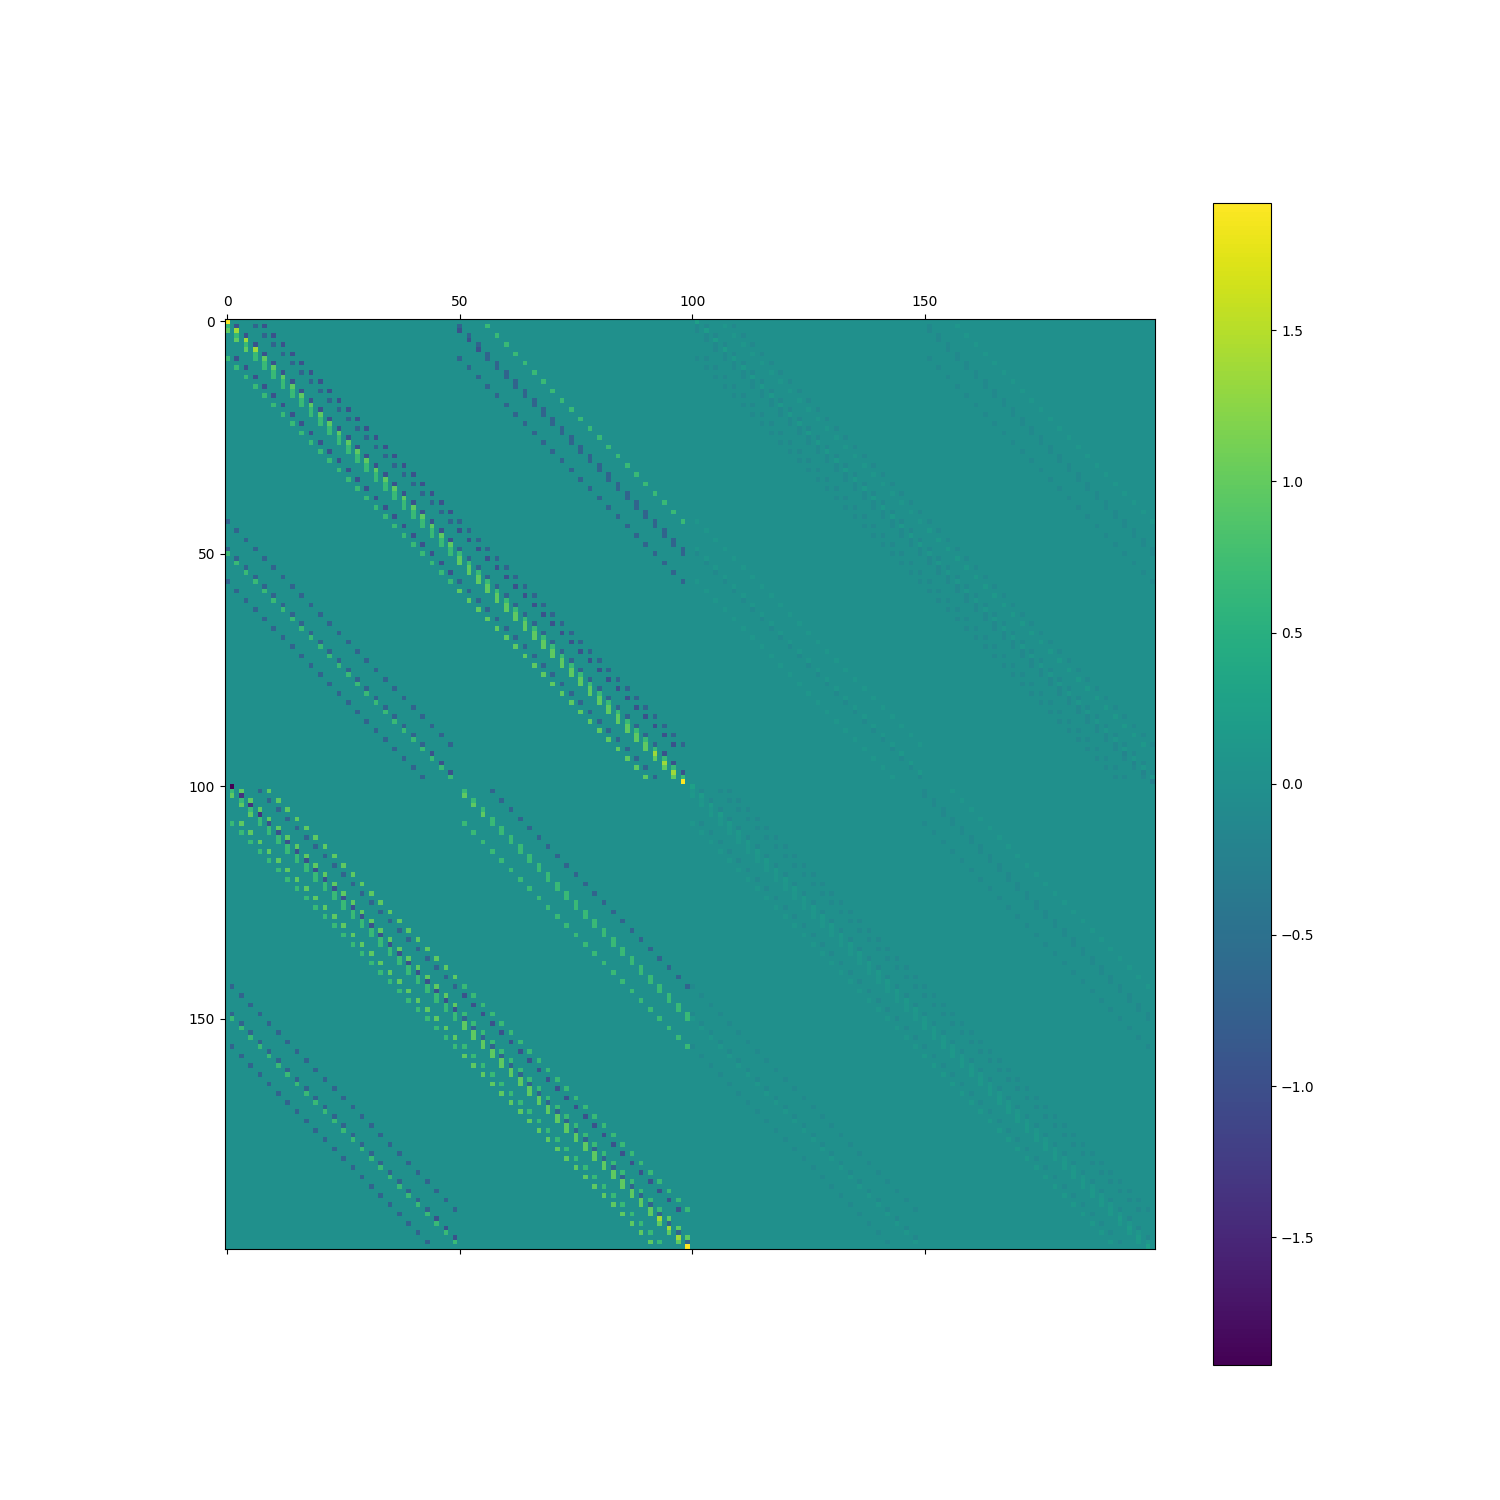

In [76]:
plt.matshow((S))
plt.colorbar()

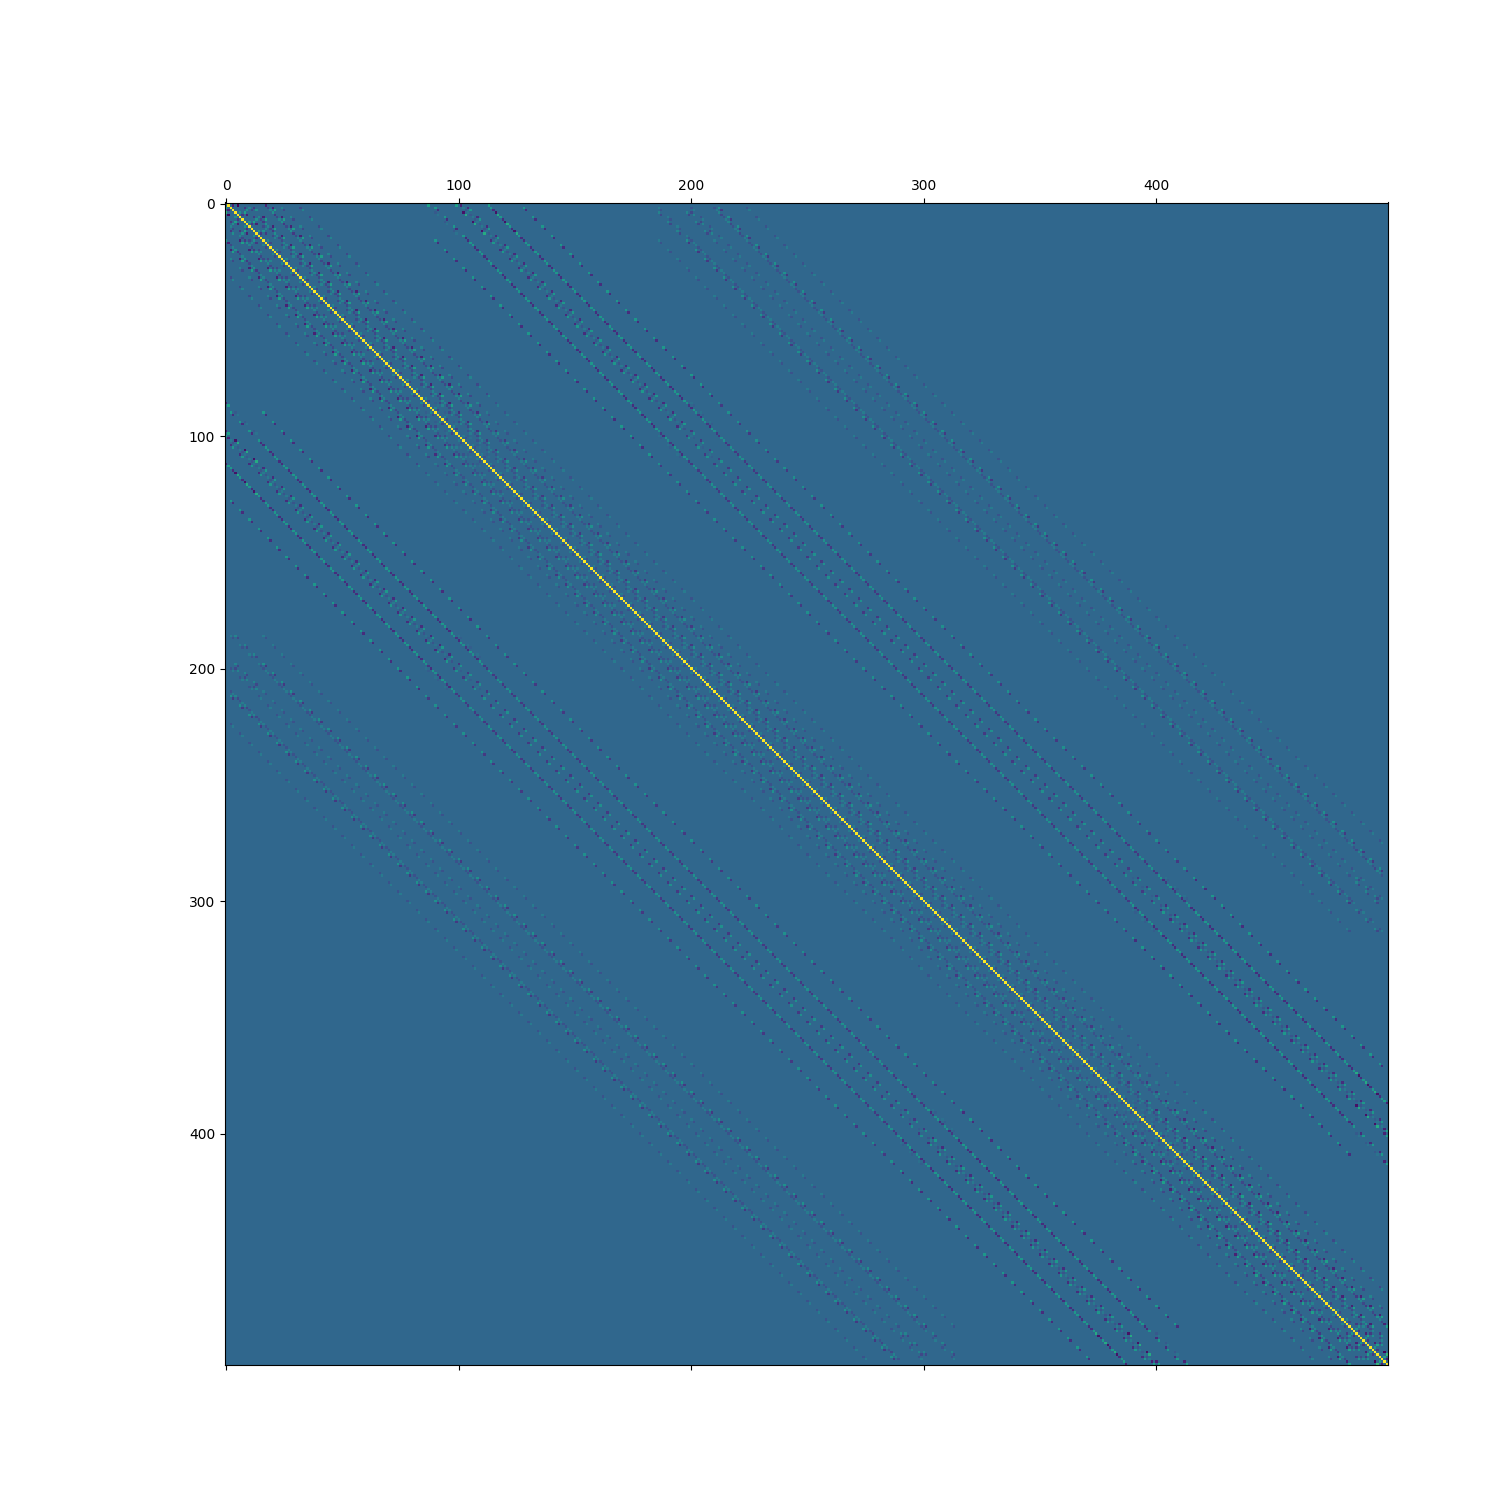

In [25]:
plt.matshow(1/2*xxpp_2_xpxp(S)@xxpp_2_xpxp(S).transpose())

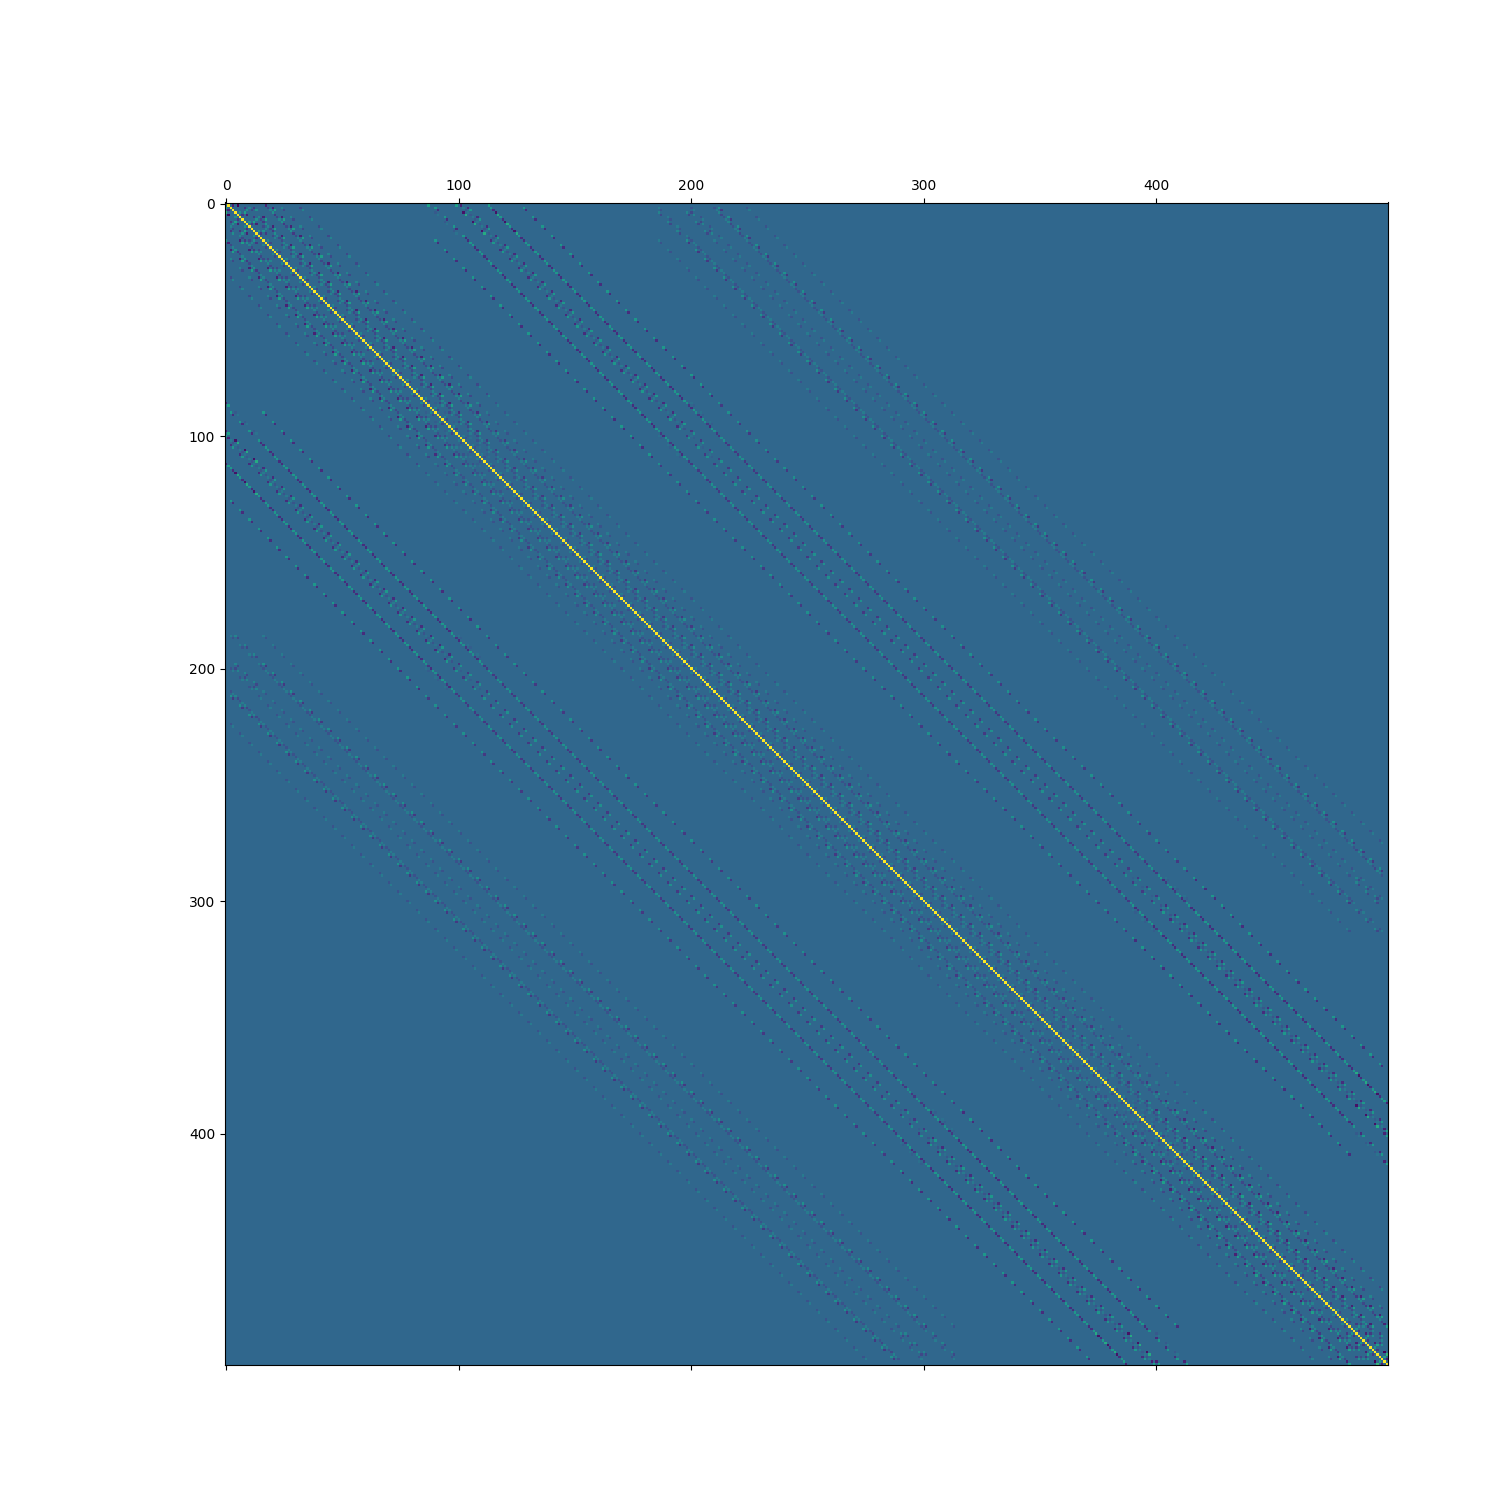

In [26]:
plt.matshow(xxpp_2_xpxp(cov))

In [27]:
def get_coordinate(i):
    is_odd = i % 2
    i = math.floor(i/2)
    y = math.floor(i/bs_1) + 0.1*is_odd
    i = i % bs_1
    z = math.floor(i/(bs_3+1))
    x = i % (bs_3+1)
    return [x,y,z]


coordinates = []
for i in range(num_modes*2):
    coordinates.append(get_coordinate(i))
coordinates = np.array(coordinates)


(0.0, 4.0)

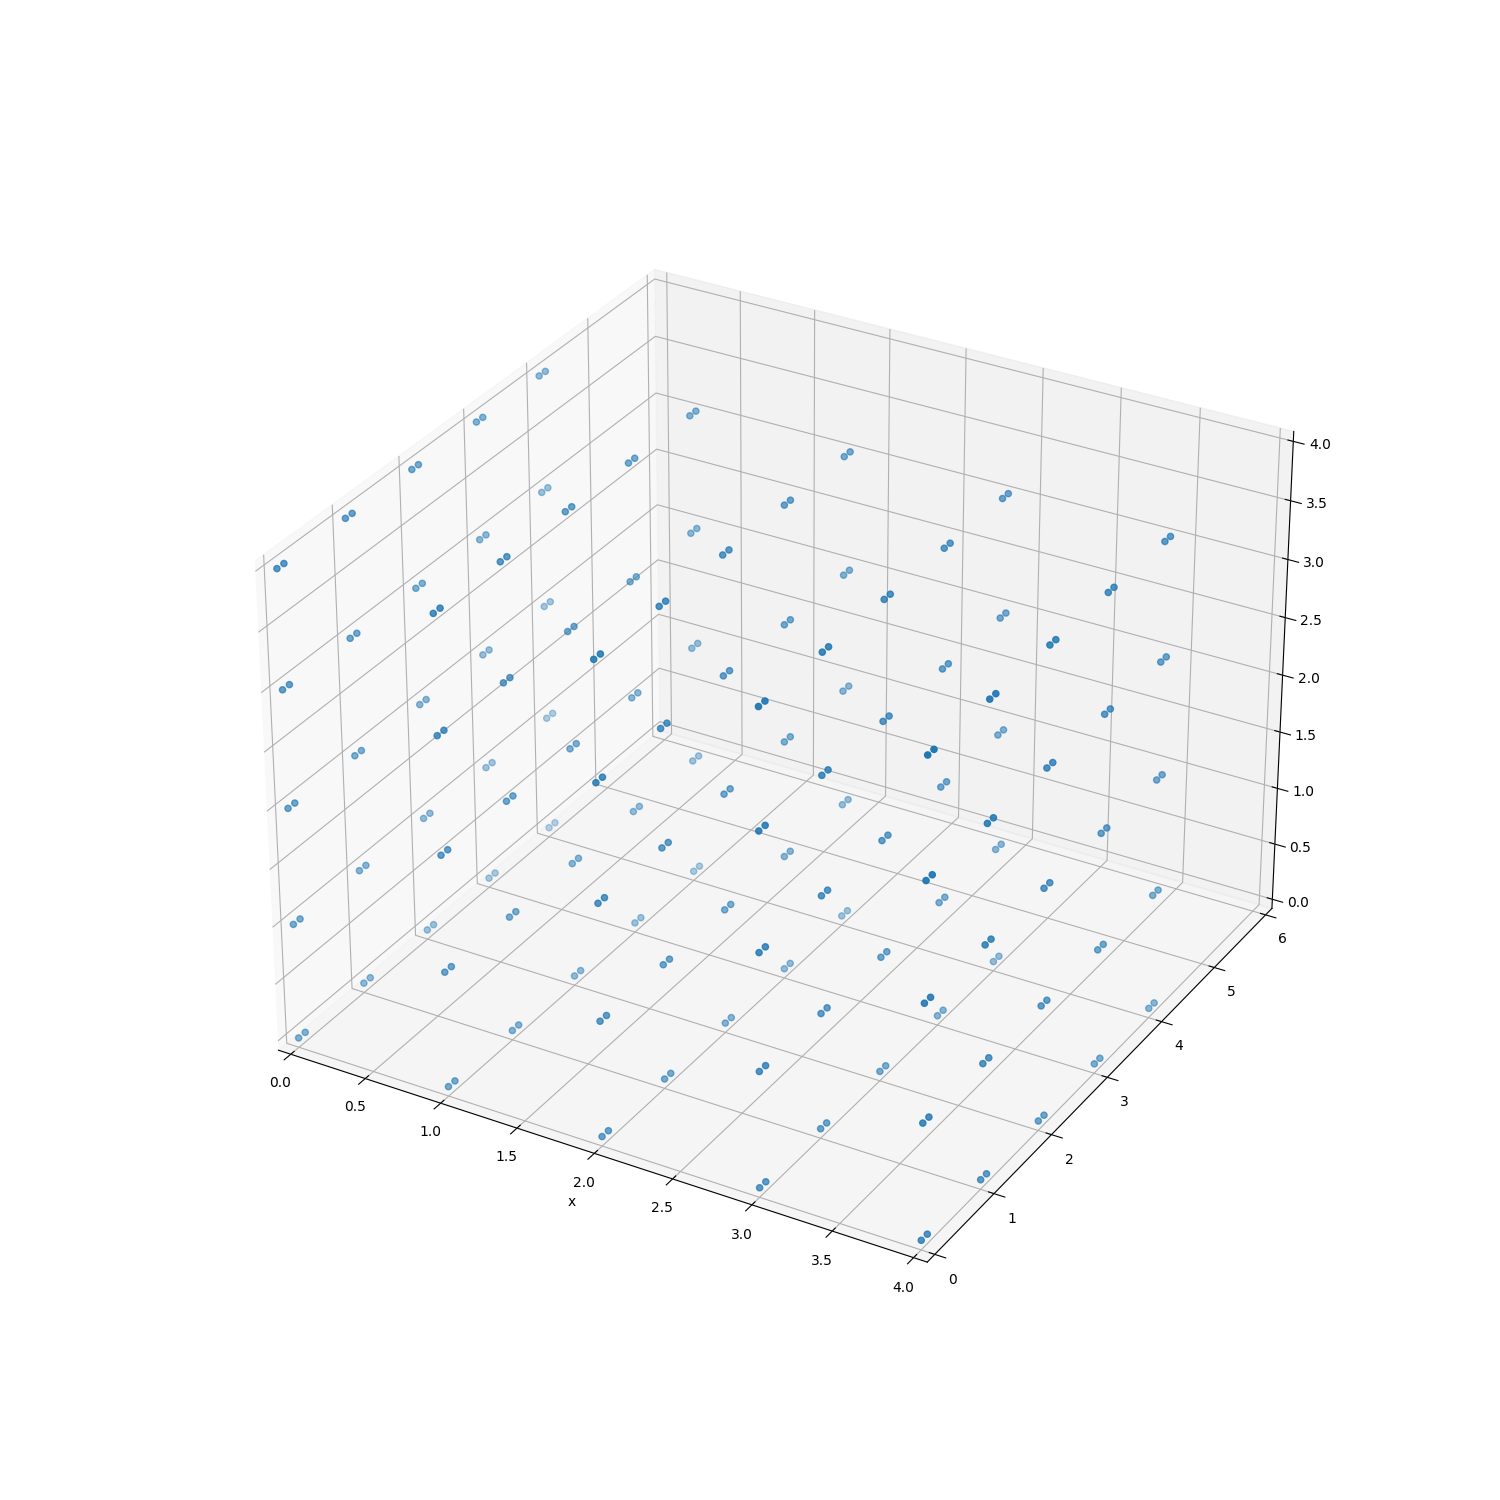

In [32]:
from mpl_toolkits import mplot3d
%matplotlib qt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(coordinates[:,0], coordinates[:,1], coordinates[:,2])
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=4) 
ax.axes.set_ylim3d(bottom=0, top=6) 
ax.axes.set_zlim3d(bottom=0, top=4) 

In [33]:
def draw_line(i,k,a,colour):
    a_coordinates = get_coordinate(i)
    b_coordinates = get_coordinate(k)
    ax.plot3D([a_coordinates[0],b_coordinates[0]],[a_coordinates[1],b_coordinates[1]],[a_coordinates[2],b_coordinates[2]], colour, alpha=a)

for i in range(num_modes*2):
    for k in range(i+1,num_modes*2):
        # if np.abs(k-i) < 2*bs_1:
        if np.abs(cov[i][k]) > 0:
            draw_line(i,k,0.1,'gray')

mode = 85
coord = get_coordinate(mode)
ax.scatter3D(coord[0], coord[1], coord[2], 'red')
for k in range(mode+1, num_modes*2):
    # if np.abs(k-mode) < 2*bs_1:
    if np.abs(cov[mode][k]) > 0:
        draw_line(mode,k,0.3,'red')
for k in range(0, mode):
    # if np.abs(k-mode) < 2*bs_1:
    if np.abs(cov[mode][k]) > 0:
        draw_line(mode,k,0.3,'red')

In [13]:
def xxpp_2_xpxp(cov):
    new_cov = np.zeros(np.shape(cov))
    
    for i in range(int(np.shape(cov)[0]/2)):
        for j in range(int(np.shape(cov)[1]/2)):
            new_cov[2*i, 2*j] = cov[i,j]
            new_cov[2*i+1, 2*j] = cov[int(np.shape(cov)[0]/2)+i, j]
            new_cov[2*i, 2*j+1] = cov[i, int(np.shape(cov)[0]/2)+j]
            new_cov[2*i+1, 2*j+1] = cov[int(np.shape(cov)[0]/2)+i, int(np.shape(cov)[0]/2)+j]
            
    return new_cov

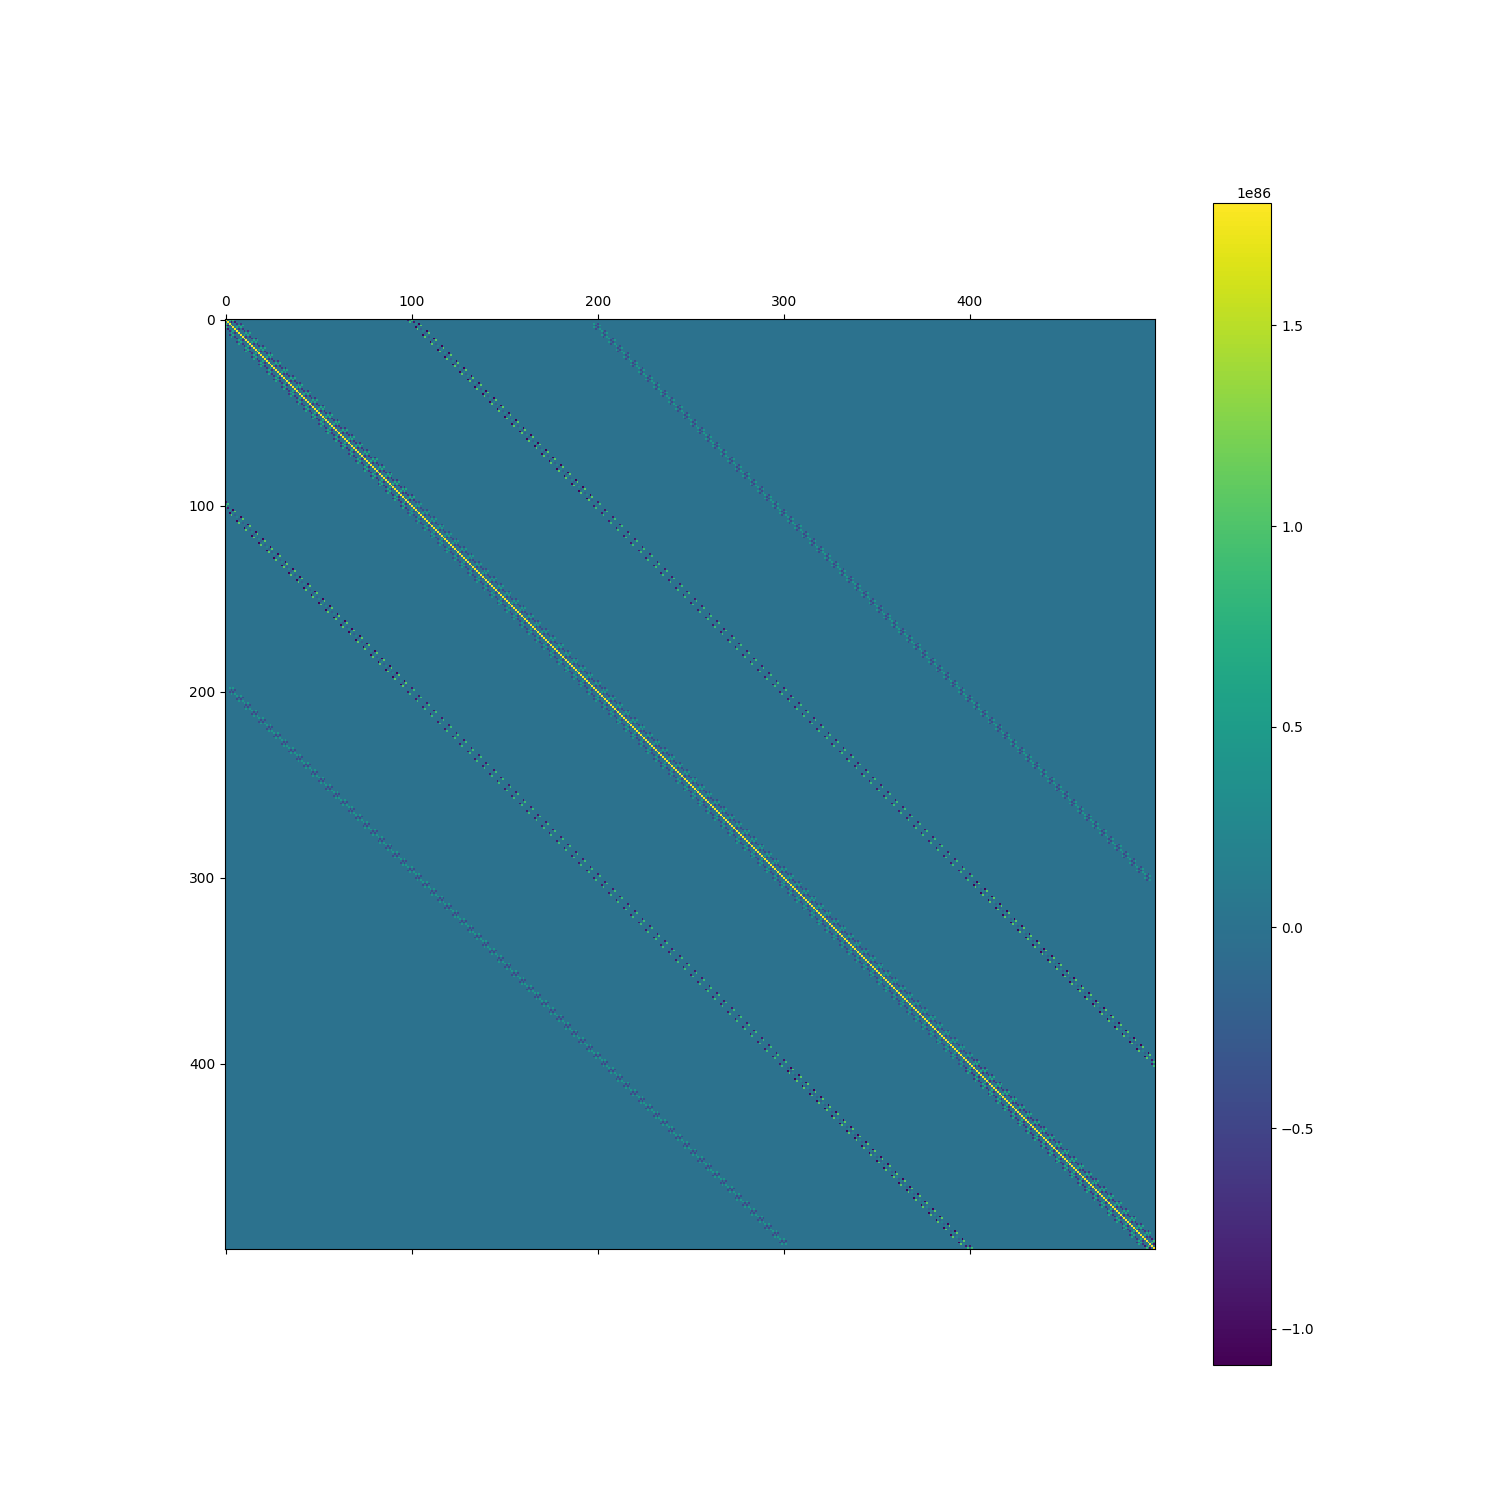

In [61]:
plt.matshow(xxpp_2_xpxp(cov))
plt.colorbar()

In [77]:
# cov = xxpp_2_xpxp(cov)

U_inv = cov[:int(np.shape(cov)[0]/2),:int(np.shape(cov)[1]/2)]
VU_inv = cov[int(np.shape(cov)[0]/2):,:int(np.shape(cov)[1]/2)]
U_invV = cov[:int(np.shape(cov)[1]/2),int(np.shape(cov)[0]/2):]

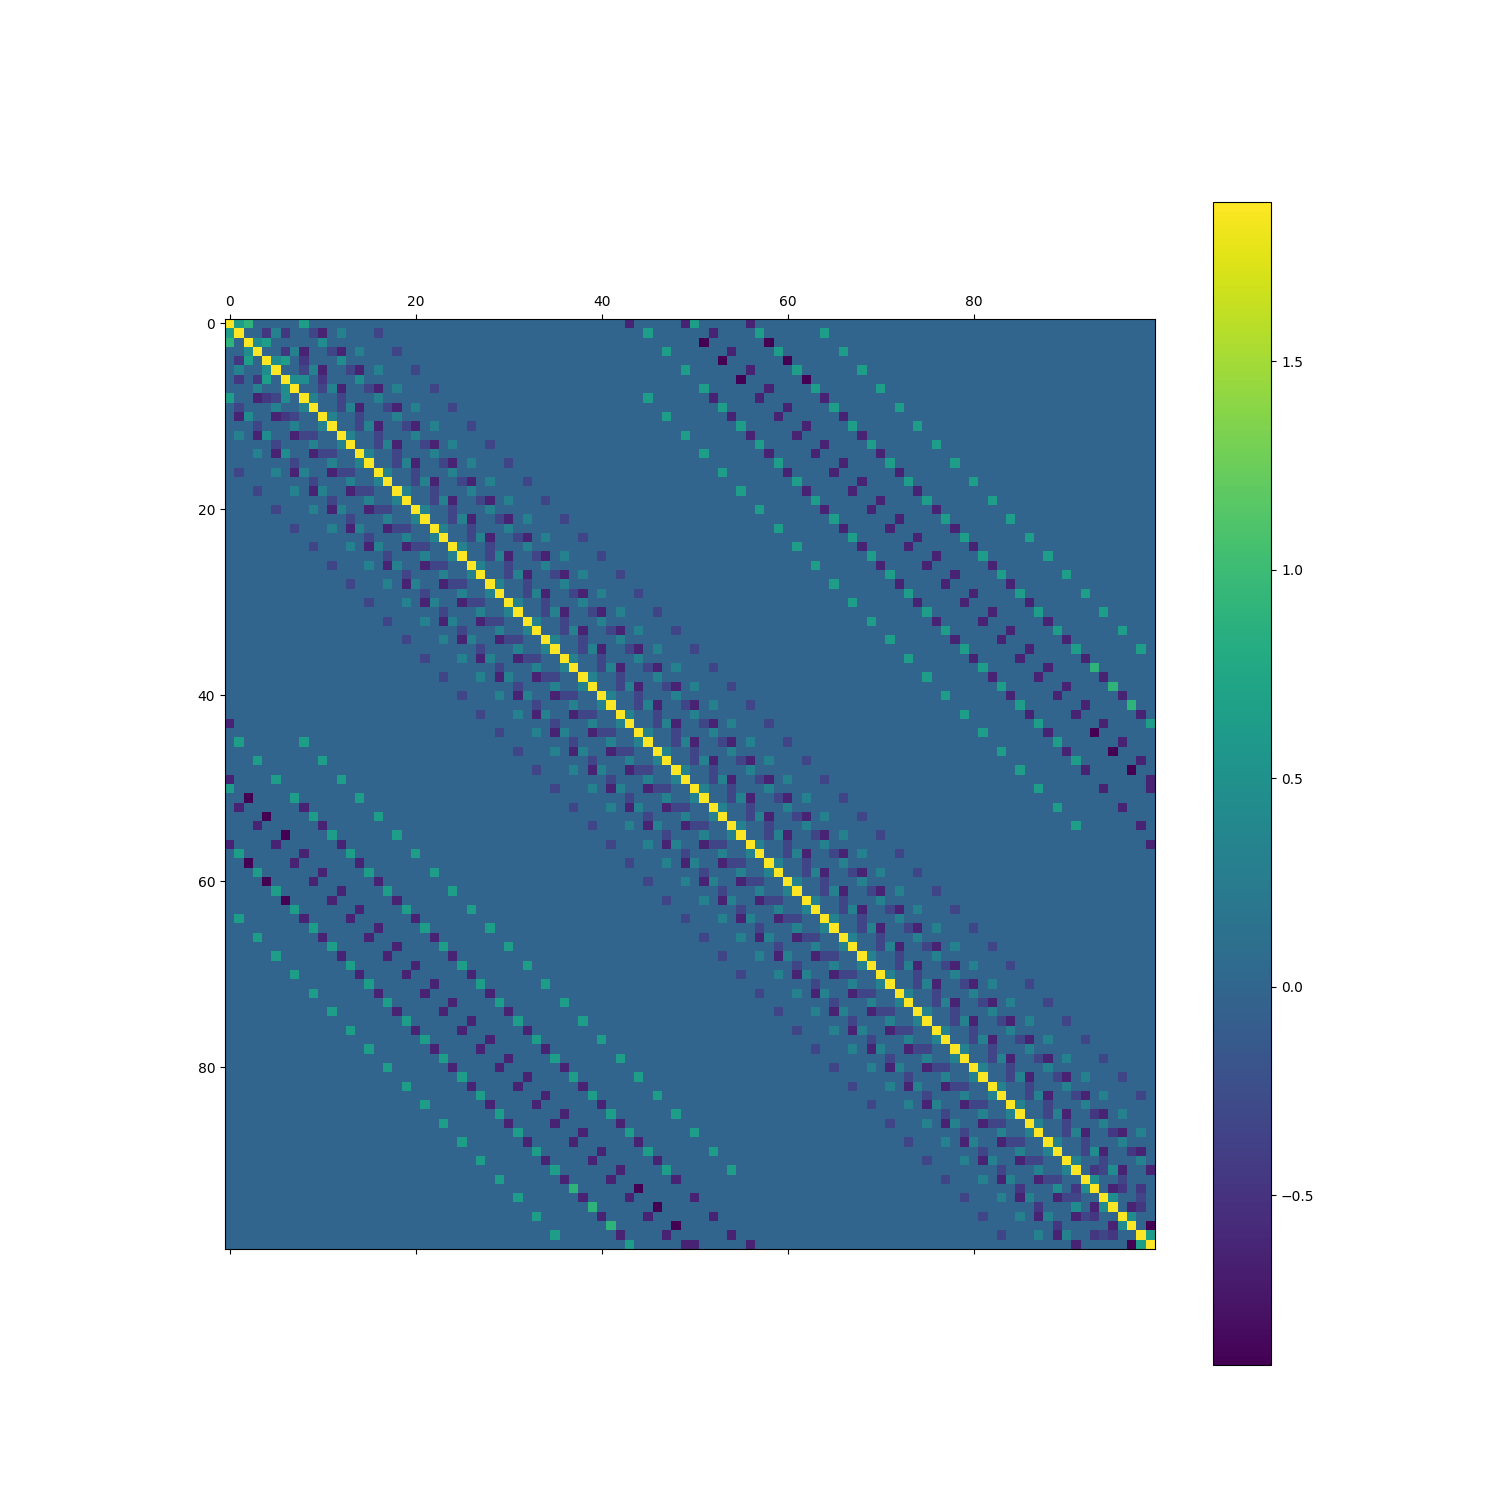

In [78]:
plt.matshow(U_inv)
plt.colorbar()

In [79]:
U = np.linalg.inv(U_inv)
V = VU_inv@U
V2 = U@U_invV

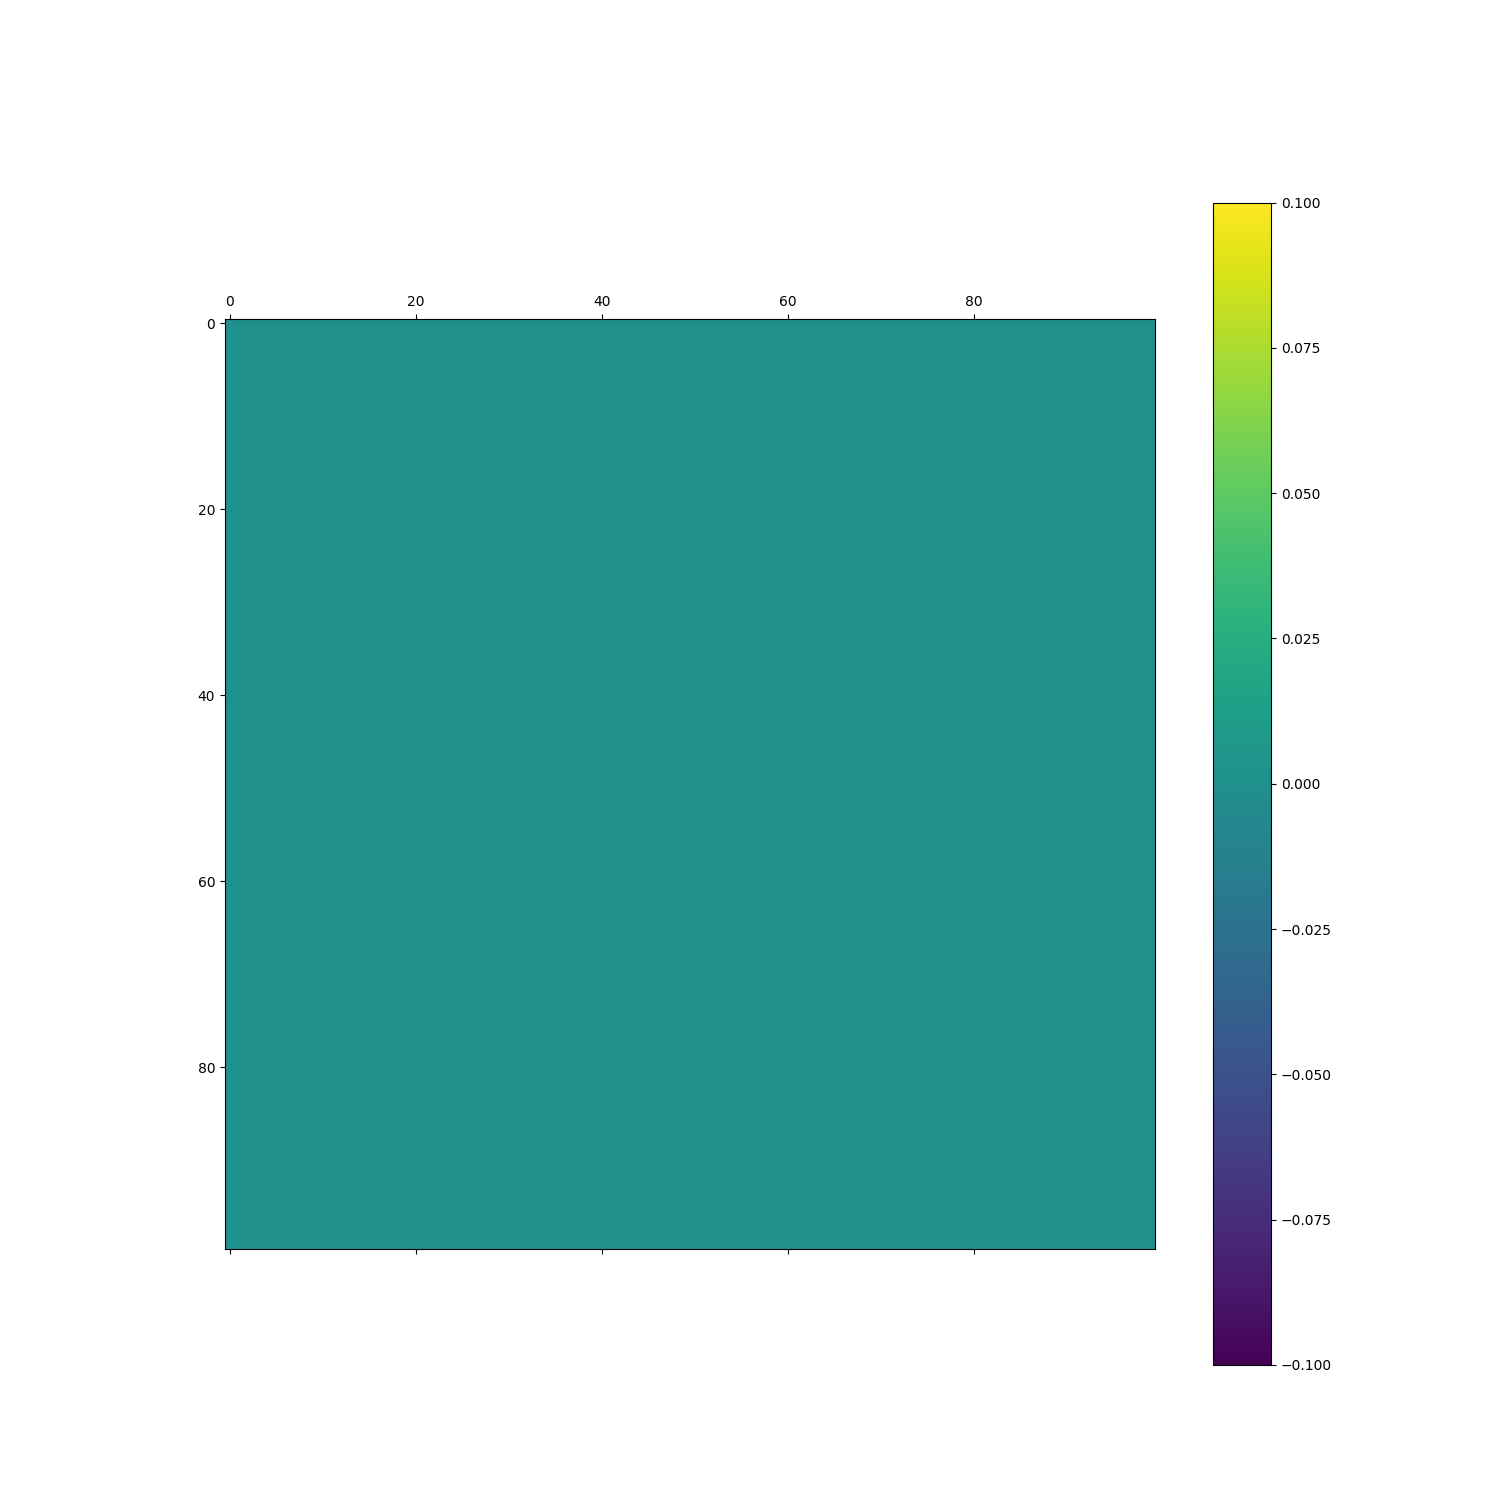

In [81]:
plt.matshow(VU_inv)
plt.colorbar()